# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [50]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')
assays = [log_S_oracle, log_P_oracle]

# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.prod(x)
)

First, set up the environment.

In [326]:
from dgym.envs.drug_env import DrugEnv

# instantiate drug_env
drug_env = DrugEnv(
    library_designer,
    library = deck[:50],
    assays = assays,
    budget = 100_000,
    utility_function=utility_function,
)

observations = drug_env.reset()

In [341]:
from dgym.agents import HardcodedDrugAgent
drug_agent = HardcodedDrugAgent(
    action_space=drug_env.action_space,
    scoring_functions=assays,
    utility_function=utility_function,
    epsilon=1.0,
    num_analogs=1
)

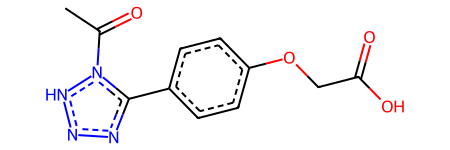

In [373]:
action = drug_agent.act(observations)
drug_env.step(action)
drug_env.library[-1]

In [376]:
action

{'type': 1, 'molecules': [40, 2, 16, 6, 21], 'parameters': {}}

In [377]:
drug_env.library[40].annotations

{'HBA': 3,
 'TPSA': 57.69,
 'RotBonds': 2,
 'reagsmi1': 'CNS(=O)(=O)C',
 'reagsmi2': 'ClCC(=O)N1CCCCC1',
 'reag1': 'EN300-33617',
 'Catalog ID': 'Z363071686',
 'MW': 234.316,
 'MW (desalted)': 234.316,
 'ClogP': 0.258,
 'logS': -0.599,
 'HBD': 0,
 'reag2': 'EN300-01775',
 'reaction': 'OXYME',
 'RDB type': 'mRDB',
 'MolLogP': -0.10970000000000013}

In [360]:
drug_env.step(action)

(MoleculeCollection with 226 Molecules, 1, False, False, {})